# 1. Получение неразмеченных изображений из видеороликов #

### В изначальном предоставленном датасете мало изображений, все они слишком похожи и имеют плохую разметку, поэтому начнём сбор нового датасета. Извлечём неразмеченные изображения из некоторой подборки видеороликов, которую мы предварительно загрузили. Затем воспользуемся библиотекой opencv и будем сохранять каждый 80-й кадр каждого видео. Полученные изображения будут иметь название видеоролика, из которого они взяты, с указанием номера кадра. Данные действия относятся к сбору и предобработке датасета, поэтому скрипты, которые были для этого использованы, будут прикреплены к проекту отдельными файлами.

# Описание датасета


### Датасет содержит 634 обучающих изображения разного размера, размеченных на 8 классов.

###Augmentations:
  - RandomRotate(degrees=10)
  - RandomTranslate()
  - RandomScale()
  - RandomShift()
  - RandomFlip()
  - RandomNoise()



# 2. Обучение детектора YOLOv8 (Transfer learning, 100 эпох)

### Воспользуемся предобученной medium версией YOLOv8. Заморозим первые 10 слоёв и произведём обучение модели в течение 100 эпох.

In [2]:
# Установка библиотеки YOLO
!pip install ultralytics --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.5/615.5 kB 12.8 MB/s eta 0:00:00


In [ ]:
# Распакова датасета в каталог /content/datasets
!mkdir /content/datasets
!unzip "/content/drive/MyDrive/Datasets/dataset.zip" -d /content/datasets

In [3]:
# Импортируем библиотеку YOLO
from ultralytics import YOLO

In [ ]:
# Загружаем предобученную medium модель
detect_model = YOLO('yolov8m.pt')

# Обучаем модель, заморозив 10 первых слоёв
results = detect_model.train(
   data='/content/datasets/dataset/data.yaml',
   imgsz=640,
   epochs=100,
   batch=8,
   freeze = 10,
   name='detection_yolo8m_100epochs')

Ultralytics YOLOv8.0.181 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/datasets/dataset/data.yaml, epochs=100, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=detection_yolo8m_100epochs, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=to

# Результаты обучения

### В результате, модель перестала показывать повышение точности после 46 эпохи. Состояние модели именно на этой эпохе будет браться для дальнейших действия.

### Данные результаты могут говорить о недостаточном количестве данных. Протестируем модель на практике, а затем попробуем разметить с помощью полученного детектора новые данные.

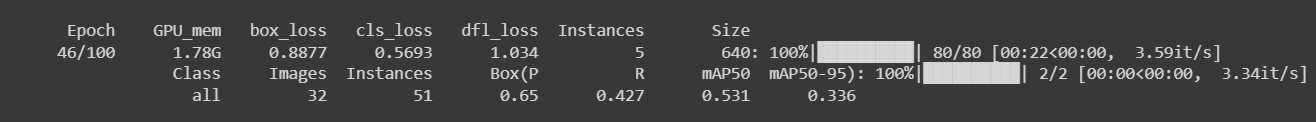

# 3. Осуществим трекинг с помощью детектора YOLOv8 и алгоритмов: ByteTrack, BoT-Sort, Strong-SORT, OC-SORT

# Протестируем модель с применением трекера ByteTrack, встроенным в YOLOv8 на тестовом наборе видео.

In [4]:
import os

# Распакуем архив с тестовыми видео
!unzip "/content/drive/MyDrive/Tracking/Test-video.zip" -d /content/datasets

# В список video сохраним пути ко всем тестовым видео для которых будет осуществлять трекинг
video = []
for file_name in os.listdir("/content/datasets/Test-video/Video"):
  video.append(os.path.join("/content/datasets/Test-video/Video", file_name))

Archive:  /content/drive/MyDrive/Tracking/Test-video.zip
   creating: /content/datasets/Test-video/Ground_truth/
  inflating: /content/datasets/Test-video/Ground_truth/gt.txt  
   creating: /content/datasets/Test-video/Video/
  inflating: /content/datasets/Test-video/Video/Test-tank.mp4  


# 3.1 ByteTrack

## Работа с данным трекером возможна с помощью библиотеки ultralytics

In [5]:
# Инициализируем детектор с весами, которые показали лучшую точность
detect_model = YOLO('/content/drive/MyDrive/Tracking/detection_yolo8m_100epochs/weights/best.pt')

In [ ]:
# Для каждого видео осуществляем Object tracking с помощью ByteTrack
for file_name in video:
  results = detect_model.track(source=file_name, save=True, tracker="bytetrack.yaml")

requirements: Ultralytics requirement ['lapx>=0.5.2'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.8 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 5.7s, installed 1 package: ['lapx>=0.5.2']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs



  0%|          | 0.00/22.2M [00:00<?, ?B/s]

video 1/1 (1/323) /content/datasets/Test-video/Test1-5.mp4: 384x640 2 САУs, 2 Танкs, 45.1ms
video 1/1 (2/323) /content/datasets/Test-video/Test1-5.mp4: 384x640 2 САУs, 2 Танкs, 27.4ms
video 1/1 (3/323) /content/datasets/Test-video/Test1-5.mp4: 384x640 2 САУs, 2 Танкs, 29.5ms
video 1/1 (4/323) /content/datasets/Test-video/Test1-5.mp4: 384x640 3 САУs, 1 Танк, 27.3ms
video 1/1 (5/323) /content/datasets/Test-video/Test1-5.mp4: 384x640 3 САУs, 1 Человек, 1 Танк, 27.4ms
video 1/1 (6/323) /content/datasets/Test-video/Test1-5.mp4: 384x640 3 САУs, 1 Человек, 1 Танк, 28.8ms
video 1/1 (7/323) /content/datasets/Test-video/Test1-5.mp4: 384x640 3 САУs, 1 Человек, 1 Танк, 27.3ms
video 1/1 (8/323) /content/datasets/Test-video/Test1-5.mp4: 384x640 3 САУs, 1 Человек, 1 Танк, 27.4ms
video 1/1 (9/323) /content/datasets/Test-video/Test1-5.mp4: 384x640 3 САУs, 1 Человек, 1 Танк, 27.3ms
video 1/1 (10/323) /content/datasets/Test-video/Test1-5.mp4: 384x640 3 САУs, 1 Человек, 1 Танк, 27.8ms
video 1/1 (11/323) /

# 3.2 BoT-SORT

In [ ]:
# Для каждого видео осуществляем Object tracking с помощью BoT-SORT
for file_name in video:
  results = detect_model.track(source=file_name, save=True, tracker="botsort.yaml")



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (1/323) /content/datasets/Test-video/Test1-5.mp4: 384x640 2 САУs, 2 Танкs, 75.0ms
video 1/1 (2/323) /content/datasets/Test-video/Test1-5.mp4: 384x640 2 САУs, 2 Танкs, 27.4ms
video 1/1 (3/323) /content/datasets/Test-video/Test1-5.mp4: 384x640 2 САУs, 2 Танкs, 27.3ms
video 1/1 (4/323) /content/datasets/Test-video/Test1-5.mp4: 384x640 3 САУs, 1 Танк, 27.3ms
video 1/1 (5/323) /content/datasets/Test-video/Test1-5.mp4: 384x640 3 САУs, 1 Человек, 1 

## Для трекеров, которые не встроены в библиотеке YOLO опишем собственную функцию для осуществления трекинга

In [6]:
# Установим библиотеку motmetrics для подсчёта метрик трекеров
!pip install motmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 kB 4.7 MB/s eta 0:00:00


In [7]:
# Утановим библиотеку boxmot, позволяющую инициализировать многие современные трекеры
!pip install boxmot --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 15.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 103.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 65.8 MB/s eta 0:00

In [49]:
'''
Функция для осуществления трекинга с помощью трекера - tracker и детектора - detect_model
videos - список путей к видео для осуществления трекинга,
color - словарь цветов для рамок в соответствии с классом объекта,
thikness - толщина рамки,
fontscale - размер шрифта,
out_path - путь для сохранения аннтоированных видео
'''
import cv2
import os
import numpy as np


def tracking(detect_model, tracker, vid_path, res_path, colors, classes, thickness, fontscale, out_path):
  # Переменная для хранения видео из videos
  vid = cv2.VideoCapture(vid_path)

  # Получаем частоту кадров и размер кадра
  fps = vid.get(cv2.CAP_PROP_FPS)
  width = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
  height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))

  # Инициализируем выходное видео, в которое будем записывать размеченные кадры исходного видео
  vid_name = os.path.basename(vid_path)
  out = cv2.VideoWriter(os.path.join(out_path, vid_name), cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

  out_result = []
  frame_num = 0
  # Начинаем цикл, который будет работать до тех пор, пока из видео можно извлечь кадры
  while True:
      # Берем кадр из видео, если этого нельзя сделать, то цикл заканчивается
      ret, im = vid.read()
      if not ret:
        break

      frame_num += 1
      # Получаем предсказания детектора на этом кадре
      result = detect_model(im)
      # Получаем представление результатов детектора в формате (x, y, x, y, conf, cls)
      for res in result:
        class_ids = res.boxes.cls.cpu().numpy()
        if len(class_ids):
          boxes = res.boxes.xyxy.cpu().numpy()
          conf = res.boxes.conf.cpu().numpy()
          yolo_res = np.concatenate((boxes, np.round(conf.reshape(-1, 1), 2), class_ids.reshape(-1, 1)), axis=1)

          # Обновляем трекер в соответствии с новыми измерениями
          tracks = tracker.update(yolo_res, im) # --> (x, y, x, y, id, conf, cls, ind)
          if len(tracks) == 0:
            out_result.append([frame_num, -1, 0, 0, 0, 0, 0])
          else:
            objects = np.repeat(frame_num, tracks.shape[0]).reshape(-1, 1)
            objects = np.concatenate((objects, np.array(tracks[:, 4]).reshape(-1, 1), np.round(np.array(tracks[:, 0:4]), 2),\
                                      np.round(np.array(tracks[:, 5]).reshape(-1, 1), 2)), axis=1)
            for obj in objects:
              out_result.append(obj)
          # Добавляем результаты трекинга в выходной массив
        else:
          tracks = np.array([])
          out_result.append([frame_num, -1, 0, 0, 0, 0, 0])

      # Если трекер содержит информацию хотя бы об одном объекте, то визуализируем данные предсказания
      if tracks.shape[0] != 0:

          xyxys = tracks[:, 0:4].astype('int') # float64 to int
          ids = tracks[:, 4].astype('int') # float64 to int
          confs = np.round(tracks[:, 5], 2)
          clss = tracks[:, 6].astype('int') # float64 to int
          inds = tracks[:, 7].astype('int') # float64 to int

          # Изменяем кадр, добавляя на него предсказания
          for xyxy, id, conf, cls in zip(xyxys, ids, confs, clss):
              color = colors[cls] if cls in colors else (0, 0, 0)  # Получите цвет на основе класса из словаря colors
              cls = classes[cls] # Получаем название полное название класса по его номеру
              im = cv2.rectangle(
                  im,
                  (xyxy[0], xyxy[1]),
                  (xyxy[2], xyxy[3]),
                  color,
                  thickness
              )
              cv2.putText(
                  im,
                  f'id: {id}, conf: {conf}, c: {cls}',
                  (xyxy[0], xyxy[1]-10),
                  cv2.FONT_HERSHEY_SIMPLEX,
                  fontscale,
                  color,
                  thickness
              )
      # Записываем кадр в выходное видео
      out.write(im)
  # Закрываем оба видео
  vid.release()
  out.release()
  with open(res_path, "w") as file:
    for array in out_result:
        file.write(",".join(map(str, array)) + "\n")

In [50]:
import cv2
import os
import numpy as np
import datetime


def tracking(detect_model, tracker, vid_path, res_path, colors, classes, thickness, fontscale, out_path):
  # Переменная для хранения видео из videos
  vid = cv2.VideoCapture(vid_path)

  # Получаем частоту кадров и размер кадра
  fps = vid.get(cv2.CAP_PROP_FPS)
  width = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
  height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))

  # Инициализируем выходное видео, в которое будем записывать размеченные кадры исходного видео
  vid_name = os.path.basename(vid_path)
  out = cv2.VideoWriter(os.path.join(out_path, vid_name), cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

  out_result = []
  frame_num = 0
  while True:
      start = datetime.datetime.now()

      ret, frame = vid.read()

      if not ret:
          break
      frame_num += 1
      # run the YOLO model on the frame
      detections = detect_model(frame)
      # initialize the list of bounding boxes and confidences
      results = np.array([]).reshape(0, 6)

      ######################################
      # DETECTION
      ######################################

      for res in detections:
          conf = res.boxes.conf.cpu().numpy()
          class_ids = res.boxes.cls.cpu().numpy()
          boxes = res.boxes.xyxy.cpu().numpy()
          results = np.vstack((results, np.concatenate((boxes, np.round(conf.reshape(-1, 1), 2), class_ids.reshape(-1, 1)), axis=1)))
      ######################################
      # TRACKING
      ######################################
      if results.shape[0] == 0:
        tracks = np.array([])
      else:
        tracks = tracker.update(results, frame)
      # Сохраняем предсказания трекера
      if len(tracks) == 0:
        out_result.append([frame_num, 0, 0, 0, 0, 0, 0])
      else:
        objects = np.repeat(frame_num, tracks.shape[0]).reshape(-1, 1)
        objects = np.concatenate((objects, np.array(tracks[:, 4]).reshape(-1, 1), np.round(np.array(tracks[:, :4]), 2),\
                                  np.round(np.array(tracks[:, 5]).reshape(-1, 1), 2)), axis=1)
        for obj in objects:
          out_result.append(obj)


      # Если трекер содержит информацию хотя бы об одном объекте, то визуализируем данные предсказания
      if tracks.shape[0] != 0:

          xyxys = tracks[:, 0:4].astype('int') # float64 to int
          ids = tracks[:, 4].astype('int') # float64 to int
          confs = np.round(tracks[:, 5], 2)
          clss = tracks[:, 6].astype('int') # float64 to int
          inds = tracks[:, 7].astype('int') # float64 to int

          # Изменяем кадр, добавляя на него предсказания
          for xyxy, id, conf, cls in zip(xyxys, ids, confs, clss):
              color = colors[cls] if cls in colors else (0, 0, 0)  # Получите цвет на основе класса из словаря colors
              cls = classes[cls] # Получаем название полное название класса по его номеру
              frame = cv2.rectangle(
                  frame,
                  (xyxy[0], xyxy[1]),
                  (xyxy[2], xyxy[3]),
                  color,
                  thickness
              )
              cv2.putText(
                  frame,
                  f'id: {id}, conf: {conf}, c: {cls}',
                  (xyxy[0], xyxy[1]-10),
                  cv2.FONT_HERSHEY_SIMPLEX,
                  fontscale,
                  color,
                  thickness
              )
      # Записываем кадр в выходное видео
      out.write(frame)

      # end time to compute the fps
      end = datetime.datetime.now()
      # show the time it took to process 1 frame
      print(f"Time to process 1 frame: {(end - start).total_seconds() * 1000:.0f} milliseconds")
      # calculate the frame per second and draw it on the frame
      fps = f"FPS: {1 / (end - start).total_seconds():.2f}"
      cv2.putText(frame, fps, (50, 50),
                  cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 8)

      # show the frame to our screen
      #cv2.imshow("Frame", frame)
      out.write(frame)
      if cv2.waitKey(1) == ord("q"):
          break

  vid.release()
  out.release()
  cv2.destroyAllWindows()
  with open(res_path, "w") as file:
    for array in out_result:
      file.write(",".join(map(str, array)) + "\n")

In [13]:
'''
Функция для подсчёта метрик на основе ground_truth в виде текстового файла и текстового файла с предсказаниями трекера
gtSource - путь к файлу с ground_truth
tSource - пути к предсказаниям трекера
'''

def motMetricsEnhancedCalculator(gtSource, tSource):
  # import required packages
  import motmetrics as mm
  import numpy as np

  gt = np.loadtxt(gtSource, delimiter=',')
  t = np.loadtxt(tSource, delimiter=',')
  acc = mm.MOTAccumulator(auto_id=True)

  for frame in range(int(gt[:,0].max())):

    gt_dets = gt[gt[:,0]==frame,1:6]
    t_dets = t[t[:,0]==frame,1:6]

    C = mm.distances.iou_matrix(gt_dets[:,1:], t_dets[:,1:], \
                                max_iou=0.5)


    acc.update(gt_dets[:,0].astype('int').tolist(), \
              t_dets[:,0].astype('int').tolist(), C)

  mh = mm.metrics.create()

  summary = mh.compute(acc, metrics=['num_frames', 'idf1', 'idp', 'idr', \
                                     'recall', 'precision', 'num_objects', \
                                     'mostly_tracked', 'partially_tracked', \
                                     'mostly_lost', 'num_false_positives', \
                                     'num_misses', 'num_switches', \
                                     'num_fragmentations', 'mota', 'motp' \
                                    ], \
                      name='acc')

  strsummary = mm.io.render_summary(
      summary,

      namemap={'idf1': 'IDF1', 'idp': 'IDP', 'idr': 'IDR', 'recall': 'Rcll', \
               'precision': 'Prcn', 'num_objects': 'GT', \
               'mostly_tracked' : 'MT', 'partially_tracked': 'PT', \
               'mostly_lost' : 'ML', 'num_false_positives': 'FP', \
               'num_misses': 'FN', 'num_switches' : 'IDsw', \
               'num_fragmentations' : 'FM', 'mota': 'MOTA', 'motp' : 'MOTP',  \
              }
  )
  print(strsummary)

## Объявим значения переменных для трекинга и визуализации результатов

In [10]:
# BRG цвета для визуализации объектов различных классов
colors = {
    0: (255, 0, 0),   # Синий
    1: (0, 255, 0),   # Зеленый
    2: (0, 255, 255), # Желтый
    3: (42, 42, 165), # Коричневый
    4: (0, 0, 255),   # Красный
    5: (128, 0, 128), # Фиолетовый
    6: (0, 0, 0),     # Черный
    7: (128, 128, 128) # Серый
}

classes = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H'
}
# Толщина рамки
thickness = 3
# Размер шрифта
fontscale = 1.4
# Путь к ground_truth файлу
gt_path = '/content/datasets/Test-video/Ground_truth/gt.txt'

# 3. StrongSORT

In [ ]:
# Импортируем StrongSORT
from boxmot import StrongSORT
from pathlib import Path


# Путь к аннотированным видео
!mkdir /content/StrongSORT
out_path = '/content/StrongSORT'
res_path = '/content/StrongSORT/result.txt'

# Пути к предсказаниям трекера
gtSource = '/content/datasets/Test-video/Ground_truth/gt.txt'
tSource = '/content/StrongSORT/result.txt'

# Проходим по всем путям видео
for vid_path in video:
  # Инициализируем трекер
  tracker = StrongSORT(
    model_weights=Path('osnet_x0_25_market1501.pt'),
    device='cuda',
    fp16=True
  )
  # Запускаем трекинг
  tracking(detect_model, tracker, vid_path, res_path, colors, classes, thickness, fontscale, out_path)
  #(detect_model, tracker, vid_path, res_path, colors, classes, thickness, fontscale, out_path, conf_threesold)
  # Подсчёт метрик
  motMetricsEnhancedCalculator(gtSource, tSource)

# 4. OC-SORT

In [ ]:
from boxmot.trackers.ocsort.ocsort import OCSort as OCSORT


# Путь к аннотированным видео
!mkdir /content/OC-SORT
out_path = '/content/OC-SORT'
res_path = '/content/OC-SORT/result.txt'

# Пути к предсказаниям трекера
gtSource = '/content/datasets/Test-video/Ground_truth/gt.txt'
tSource = '/content/OC-SORT/result.txt'

# Проходим по всем путям видео
for vid_path in video:
  # Инициализируем трекер
  tracker = OCSORT()
  # Запускаем трекинг
  tracking(detect_model, tracker, vid_path, res_path, colors, classes, thickness, fontscale, out_path)
  # Подсчёт метрик
  motMetricsEnhancedCalculator(gtSource, tSource)

mkdir: cannot create directory ‘/content/OC-SORT’: File exists



0: 384x640 (no detections), 26.3ms
Speed: 4.8ms preprocess, 26.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Танк, 25.9ms
Speed: 2.1ms preprocess, 25.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 Танкs, 25.8ms
Speed: 1.9ms preprocess, 25.8ms inference, 6.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Танк, 27.1ms
Speed: 5.4ms preprocess, 27.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Танк, 25.1ms
Speed: 4.2ms preprocess, 25.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Танк, 24.2ms
Speed: 2.5ms preprocess, 24.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Танк, 24.3ms
Speed: 4.0ms preprocess, 24.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 Танкs, 25.2ms
Speed: 1.8ms preprocess, 25.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 64

     num_frames      IDF1       IDP       IDR      Rcll      Prcn   GT  MT  PT  ML   FP   FN  IDsw  FM      MOTA      MOTP
acc         247  0.103333  0.111111  0.108392  0.097902  0.089172  286   0   0   2  286  258     2   7 -0.909091  0.464168
